In [28]:
#getting source file and creating creating week vise excel files with rfm score get cluster and segmentation
#-----------------------------------1st script-----------------------------------------------------------------------------------
import glob
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore")
import re

# Set the paths for the input and output folders
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/input_test/test/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/weekly_input_data/"

# Set the path of the folder you want to get file names from
folder_path = "C:/Users/GCV/Documents/MAS/Project AR/Testing/input_test/test/"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern_xlsx = folder_path + "*.xlsx"
file_pattern_xls = folder_path + "*.xls"
file_pattern_xlsm = folder_path + "*.xlsm"

# Use glob function to get the file names that match each file pattern
file_names_xlsx = glob.glob(file_pattern_xlsx)
file_names_xls = glob.glob(file_pattern_xls)
file_names_xlsm = glob.glob(file_pattern_xlsm)


# Loop through each file name and process the corresponding Excel file
for file_name in file_names_xlsx:
        for file in glob.glob('./*.xlsx'):
                if '~$' in file:
                    continue

        
        # Read the Excel file into a pandas DataFrame
        df = pd.read_excel(file_name,sheet_name='Breakdown External ')

        #creating cp pivot table
        pivot_table_cp = pd.pivot_table(df, values='CP',index=['Customer Name'] , aggfunc = 'max')
       
    
        # Get a boolean mask of the columns that contain "Amount"
        # mask = df.columns.str.contains("Amount")
        # df.loc[:, mask] = df.loc[:, mask].rename(columns=lambda x: x.replace("Amount", "Amount in USD"))

        
        #rename some changeable column names into a unique name
        if 'Amount' in df.columns:
            df = df.rename(columns={'Amount': 'Amount in USD'})
        elif 'Amount in local currency' in df.columns:
            df = df.rename(columns={'Amount in local currency': 'Amount in USD'})
        elif "Ageing as at 27th October'22" in df.columns:
            df = df.rename(columns={"Ageing as at 27th October'22": 'Ageing'})
        
            
        #convert 'Amount in USD' column's data type into numeric
        df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')
        #creating ageing pivot table
        #print(file_name)
        pivot_table_ageing = pd.pivot_table(df, values='Amount in USD',index=['Customer Name'] , columns=['Ageing'], aggfunc = 'sum')

        #filling null values with zeros
        pivot_table_ageing = pivot_table_ageing.fillna(0)

        #concat 2 pivot tables 
        summary_df=pd.concat([pivot_table_ageing, pivot_table_cp['CP']], axis=1)

        #removing negative values in data frame
        summary_df = summary_df.applymap(lambda x: max(0, x))

        summary_df['Customer Name'] = summary_df.index
        summary_df = summary_df.reset_index(drop=True)
       
        #some column name has 0-30 Days so remove Days from name
        summary_df.columns = summary_df.columns.str.replace(' Days', '')

        if 'Above 120' in summary_df.columns:
            summary_df = summary_df.rename(columns={'Above 120': '120 Above'})

        summary_subset1 = summary_df[['CP', '0-30', '31-45', '46-60','61-90','91-120','120 Above']]
        summary_subset2 = summary_df[['Customer Name']]
        def replace_values(row):
            if row['CP'] > 30:
                row['0-30'] = 0
            if row['CP'] > 45:
                row['31-45'] = 0
            if row['CP'] > 60:
                row['46-60'] = 0
            if row['CP'] > 90:
                row['61-90'] = 0
            if row['CP'] > 120:
                row['91-120'] = 0
            if row['CP'] > 120:
                row['120 Above'] = 0

            return row

        # apply the function to each row of the data frame
        summary_subset1 = summary_subset1.apply(replace_values, axis=1)
        summary_df = pd.concat([summary_subset2,summary_subset1],axis=1)
        
        # Convert all column names to strings
        df.columns = df.columns.map(str)

        # Define the regular expression to match the date format
        date_regex = r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}'

        # Find the column name that matches the date format
        date_col_name = next((col for col in df.columns if re.match(date_regex, col)), None)

        # Rename the date column to a more appropriate name
        if date_col_name:
            df.rename(columns={date_col_name: 'overdue_dates'}, inplace=True)

        #df.columns = original_column_labels
        #df.columns = df.columns.tolist()
        #print(df.columns)

        df_monetary = df[['Customer Name','Amount in USD','CP','overdue_dates']]
        #df_monetary.head()


        # define a function to apply to 'overdue_dates' column and create the new column
        def create_new_col(row):
            if row['overdue_dates'] > row['CP']:
                return row['Amount in USD']
            else:
                return 0
   
        # apply the function to create the new column
        df_monetary['M'] = df_monetary.apply(create_new_col, axis=1)

        # # Convert negative values in column  to 0
        # df_monetary['M'] = df_monetary['M'].clip(lower=0)
        # df_monetary['M'] = df_monetary['M'].clip(lower=0)
        
        
        #print(df_monetary.head())


        pivot_table_monetary = pd.pivot_table(df_monetary, values=['Amount in USD', 'M'],index=['Customer Name'] , aggfunc = 'sum')
        pivot_table_monetary = pivot_table_monetary.rename(columns={'Amount in USD': 'Total Receivable'})

        
        #print(pivot_table_monetary.head())
        
        
        
        #calculating frequency
        # define a custom function to count the number of values greater than 0 in a list
        def freq(lst):
            return sum([1 for x in lst if x > 0])
        # create new subsets of the DataFrame using .loc
        df_subset4 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset6 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset5 = summary_df.loc[:, ['Customer Name', 'CP']]

        # create new columns using .loc and avoid chained indexing
        df_subset4.loc[:, 'F'] = df_subset4.apply(lambda row: freq(row.tolist()), axis=1)
        df_subset6.loc[:, 'RowSum'] = df_subset6.sum(axis=1)
        #df_subset4.loc[:, 'M'] = df_subset6.loc[:, 'RowSum']

        # concatenate the subsets into a new DataFrame
        summary_df = pd.concat([df_subset5, df_subset4], axis=1)
        summary_df = pd.merge(summary_df,pivot_table_monetary,on='Customer Name')
        #print(summary_df.head())
        
        
        
        

        df_subset7 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above','M','Total Receivable']]
        df_subset8 = summary_df.loc[:, ['Customer Name', 'CP','F']]

        def calc_R(row):
            # Calculate the divisor (total value for the row)
            total = row['M']
            # Calculate the weights and apply to the values in the row
            if total == 0:
                return None
            else:
                weights = [0.083333333, 2.5, 3.75, 5, 7.5, 10]
                values = [row['0-30'], row['31-45'], row['46-60'], row['61-90'], row['91-120'], row['120 Above']]
                weighted_values = [value * weight / total for value, weight in zip(values, weights)]
                # Sum the weighted values to get the final R value
                return sum(weighted_values)

        # Apply the custom function to each row and store the result in a new column 'R'
        df_subset7['R'] = df_subset7.apply(calc_R, axis=1)
        df_subset7.head()
        summary_df = pd.concat([df_subset8, df_subset7], axis=1)
        summary_df=summary_df.fillna(0)
        summary_df = summary_df[['Customer Name', 'CP' , '0-30', '31-45', '46-60', '61-90',
               '91-120', '120 Above', 'R', 'F','M','Total Receivable']]
        nature_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Automation\Nature.xlsx')
            #left join on both data frame
        merged_df = pd.merge(summary_df ,nature_df ,on="Customer Name", how="left") #both column name of customer shoul be same if not remane both column as customer
        merged_df["nature of the business"].fillna(0, inplace=True)
        summary_df['N'] = merged_df["nature of the business"]
        #drop rows where N and M column vlaues 0
        mask1 = summary_df['N'] != 0 
        summary_df = summary_df[mask1]
        mask2 = summary_df['M'] != 0
        summary_df = summary_df[mask2]

        summary_df =summary_df.reset_index(drop=True)

        final_df = summary_df[['Customer Name','R','F','M','N','Total Receivable']]
        #print(final_df.head())
        #final_df.to_excel('W16.xlsx',index=False)
        
        #convert negative values into 0
        def convert_negatives_to_zero(df, col_name):
            df[col_name] = df[col_name].apply(lambda x: max(0, x))
            return df
        
        final_df = convert_negatives_to_zero(final_df,'M')
        final_df = convert_negatives_to_zero(final_df,'Total Receivable')
        
        
        #print(file_name)
        # Construct the output file name based on the input file name
        output_file_name = os.path.join(output_folder, os.path.basename(file_name))
        output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
        # Write the processed DataFrame to the output file
        final_df.to_excel(output_file_name, index=False)# Convert all column names to strings
        
#------------------------------xls files-----------------------------------------------------------------------------        
# Loop through each file name and process the corresponding Excel file
for file_name in file_names_xls:
        for file in glob.glob('./*.xls'):
                if '~$' in file:
                    continue

        
        # Read the Excel file into a pandas DataFrame
        df = pd.read_excel(file_name,sheet_name='Breakdown External ')

        #creating cp pivot table
        pivot_table_cp = pd.pivot_table(df, values='CP',index=['Customer Name'] , aggfunc = 'max')
       
    
        # Get a boolean mask of the columns that contain "Amount"
        # mask = df.columns.str.contains("Amount")
        # df.loc[:, mask] = df.loc[:, mask].rename(columns=lambda x: x.replace("Amount", "Amount in USD"))

        
        #rename some changeable column names into a unique name
        if 'Amount' in df.columns:
            df = df.rename(columns={'Amount': 'Amount in USD'})
        elif 'Amount in local currency' in df.columns:
            df = df.rename(columns={'Amount in local currency': 'Amount in USD'})
        elif "Ageing as at 27th October'22" in df.columns:
            df = df.rename(columns={"Ageing as at 27th October'22": 'Ageing'})
        
            
        #convert 'Amount in USD' column's data type into numeric
        df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')
        #creating ageing pivot table
        #print(file_name)
        pivot_table_ageing = pd.pivot_table(df, values='Amount in USD',index=['Customer Name'] , columns=['Ageing'], aggfunc = 'sum')

        #filling null values with zeros
        pivot_table_ageing = pivot_table_ageing.fillna(0)

        #concat 2 pivot tables 
        summary_df=pd.concat([pivot_table_ageing, pivot_table_cp['CP']], axis=1)

        #removing negative values in data frame
        summary_df = summary_df.applymap(lambda x: max(0, x))

        summary_df['Customer Name'] = summary_df.index
        summary_df = summary_df.reset_index(drop=True)
       
        #some column name has 0-30 Days so remove Days from name
        summary_df.columns = summary_df.columns.str.replace(' Days', '')

        if 'Above 120' in summary_df.columns:
            summary_df = summary_df.rename(columns={'Above 120': '120 Above'})

        summary_subset1 = summary_df[['CP', '0-30', '31-45', '46-60','61-90','91-120','120 Above']]
        summary_subset2 = summary_df[['Customer Name']]
        def replace_values(row):
            if row['CP'] > 30:
                row['0-30'] = 0
            if row['CP'] > 45:
                row['31-45'] = 0
            if row['CP'] > 60:
                row['46-60'] = 0
            if row['CP'] > 90:
                row['61-90'] = 0
            if row['CP'] > 120:
                row['91-120'] = 0
            if row['CP'] > 120:
                row['120 Above'] = 0

            return row

        # apply the function to each row of the data frame
        summary_subset1 = summary_subset1.apply(replace_values, axis=1)
        summary_df = pd.concat([summary_subset2,summary_subset1],axis=1)
        
        # Convert all column names to strings
        df.columns = df.columns.map(str)

        # Define the regular expression to match the date format
        date_regex = r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}'

        # Find the column name that matches the date format
        date_col_name = next((col for col in df.columns if re.match(date_regex, col)), None)

        # Rename the date column to a more appropriate name
        if date_col_name:
            df.rename(columns={date_col_name: 'overdue_dates'}, inplace=True)

        #df.columns = original_column_labels
        #df.columns = df.columns.tolist()
        #print(df.columns)

        df_monetary = df[['Customer Name','Amount in USD','CP','overdue_dates']]
        #df_monetary.head()


        # define a function to apply to 'overdue_dates' column and create the new column
        def create_new_col(row):
            if row['overdue_dates'] > row['CP']:
                return row['Amount in USD']
            else:
                return 0

        # apply the function to create the new column
        df_monetary['M'] = df_monetary.apply(create_new_col, axis=1)

        #print(df_monetary.head())


        pivot_table_monetary = pd.pivot_table(df_monetary, values=['Amount in USD', 'M'],index=['Customer Name'] , aggfunc = 'sum')
        pivot_table_monetary = pivot_table_monetary.rename(columns={'Amount in USD': 'Total Receivable'})

        
        #print(pivot_table_monetary.head())
        
        
        
        #calculating frequency
        # define a custom function to count the number of values greater than 0 in a list
        def freq(lst):
            return sum([1 for x in lst if x > 0])
        # create new subsets of the DataFrame using .loc
        df_subset4 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset6 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset5 = summary_df.loc[:, ['Customer Name', 'CP']]

        # create new columns using .loc and avoid chained indexing
        df_subset4.loc[:, 'F'] = df_subset4.apply(lambda row: freq(row.tolist()), axis=1)
        df_subset6.loc[:, 'RowSum'] = df_subset6.sum(axis=1)
        #df_subset4.loc[:, 'M'] = df_subset6.loc[:, 'RowSum']

        # concatenate the subsets into a new DataFrame
        summary_df = pd.concat([df_subset5, df_subset4], axis=1)
        summary_df = pd.merge(summary_df,pivot_table_monetary,on='Customer Name')
        #print(summary_df.head())
       
        # Convert negative values in column  to 0
        summary_df['M'] = summary_df['M'].clip(lower=0)
        summary_df['Total Receivable'] = summary_df['Total Receivable'].clip(lower=0)

        
        

        df_subset7 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above','M','Total Receivable']]
        df_subset8 = summary_df.loc[:, ['Customer Name', 'CP','F']]

        def calc_R(row):
            # Calculate the divisor (total value for the row)
            total = row['M']
            # Calculate the weights and apply to the values in the row
            if total == 0:
                return None
            else:
                weights = [0.083333333, 2.5, 3.75, 5, 7.5, 10]
                values = [row['0-30'], row['31-45'], row['46-60'], row['61-90'], row['91-120'], row['120 Above']]
                weighted_values = [value * weight / total for value, weight in zip(values, weights)]
                # Sum the weighted values to get the final R value
                return sum(weighted_values)

        # Apply the custom function to each row and store the result in a new column 'R'
        df_subset7['R'] = df_subset7.apply(calc_R, axis=1)
        df_subset7.head()
        summary_df = pd.concat([df_subset8, df_subset7], axis=1)
        summary_df=summary_df.fillna(0)
        summary_df = summary_df[['Customer Name', 'CP' , '0-30', '31-45', '46-60', '61-90',
               '91-120', '120 Above', 'R', 'F','M','Total Receivable']]
        nature_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Automation\Nature.xlsx')
            #left join on both data frame
        merged_df = pd.merge(summary_df ,nature_df ,on="Customer Name", how="left") #both column name of customer shoul be same if not remane both column as customer
        merged_df["nature of the business"].fillna(0, inplace=True)
        summary_df['N'] = merged_df["nature of the business"]
        #drop rows where N and M column vlaues 0
        mask1 = summary_df['N'] != 0 
        summary_df = summary_df[mask1]
        mask2 = summary_df['M'] != 0
        summary_df = summary_df[mask2]

        summary_df =summary_df.reset_index(drop=True)

        final_df = summary_df[['Customer Name','R','F','M','N','Total Receivable']]
        #print(final_df.head())
        #final_df.to_excel('W16.xlsx',index=False)

        
        #convert negative values into 0
        def convert_negatives_to_zero(df, col_name):
            df[col_name] = df[col_name].apply(lambda x: max(0, x))
            return df
        
        final_df = convert_negatives_to_zero(final_df,'M')
        final_df = convert_negatives_to_zero(final_df,'Total Receivable')

        
        
        #print(file_name)
        # Construct the output file name based on the input file name
        output_file_name = os.path.join(output_folder, os.path.basename(file_name))
        output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
        # Write the processed DataFrame to the output file
        final_df.to_excel(output_file_name, index=False)# Convert all column names to strings
 
        
#------------------------xlsm-----------------------------------------------------------------------------------       
 # Loop through each file name and process the corresponding Excel file
for file_name in file_names_xlsm:
        for file in glob.glob('./*.xlsm'):
                if '~$' in file:
                    continue

        
        # Read the Excel file into a pandas DataFrame
        df = pd.read_excel(file_name,sheet_name='Breakdown External ')

        #creating cp pivot table
        pivot_table_cp = pd.pivot_table(df, values='CP',index=['Customer Name'] , aggfunc = 'max')
       
    
        # Get a boolean mask of the columns that contain "Amount"
        # mask = df.columns.str.contains("Amount")
        # df.loc[:, mask] = df.loc[:, mask].rename(columns=lambda x: x.replace("Amount", "Amount in USD"))

        
        #rename some changeable column names into a unique name
        if 'Amount' in df.columns:
            df = df.rename(columns={'Amount': 'Amount in USD'})
        elif 'Amount in local currency' in df.columns:
            df = df.rename(columns={'Amount in local currency': 'Amount in USD'})
        elif "Ageing as at 27th October'22" in df.columns:
            df = df.rename(columns={"Ageing as at 27th October'22": 'Ageing'})
        
            
        #convert 'Amount in USD' column's data type into numeric
        df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')
        #creating ageing pivot table
        #print(file_name)
        pivot_table_ageing = pd.pivot_table(df, values='Amount in USD',index=['Customer Name'] , columns=['Ageing'], aggfunc = 'sum')

        #filling null values with zeros
        pivot_table_ageing = pivot_table_ageing.fillna(0)

        #concat 2 pivot tables 
        summary_df=pd.concat([pivot_table_ageing, pivot_table_cp['CP']], axis=1)

        #removing negative values in data frame
        summary_df = summary_df.applymap(lambda x: max(0, x))

        summary_df['Customer Name'] = summary_df.index
        summary_df = summary_df.reset_index(drop=True)
       
        #some column name has 0-30 Days so remove Days from name
        summary_df.columns = summary_df.columns.str.replace(' Days', '')

        if 'Above 120' in summary_df.columns:
            summary_df = summary_df.rename(columns={'Above 120': '120 Above'})

        summary_subset1 = summary_df[['CP', '0-30', '31-45', '46-60','61-90','91-120','120 Above']]
        summary_subset2 = summary_df[['Customer Name']]
        def replace_values(row):
            if row['CP'] > 30:
                row['0-30'] = 0
            if row['CP'] > 45:
                row['31-45'] = 0
            if row['CP'] > 60:
                row['46-60'] = 0
            if row['CP'] > 90:
                row['61-90'] = 0
            if row['CP'] > 120:
                row['91-120'] = 0
            if row['CP'] > 120:
                row['120 Above'] = 0

            return row

        # apply the function to each row of the data frame
        summary_subset1 = summary_subset1.apply(replace_values, axis=1)
        summary_df = pd.concat([summary_subset2,summary_subset1],axis=1)
        
        # Convert all column names to strings
        df.columns = df.columns.map(str)

        # Define the regular expression to match the date format
        date_regex = r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}'

        # Find the column name that matches the date format
        date_col_name = next((col for col in df.columns if re.match(date_regex, col)), None)

        # Rename the date column to a more appropriate name
        if date_col_name:
            df.rename(columns={date_col_name: 'overdue_dates'}, inplace=True)

        #df.columns = original_column_labels
        #df.columns = df.columns.tolist()
        #print(df.columns)

        df_monetary = df[['Customer Name','Amount in USD','CP','overdue_dates']]
        #df_monetary.head()


        # define a function to apply to 'overdue_dates' column and create the new column
        def create_new_col(row):
            if row['overdue_dates'] > row['CP']:
                return row['Amount in USD']
            else:
                return 0

        # apply the function to create the new column
        df_monetary['M'] = df_monetary.apply(create_new_col, axis=1)

        #print(df_monetary.head())


        pivot_table_monetary = pd.pivot_table(df_monetary, values=['Amount in USD', 'M'],index=['Customer Name'] , aggfunc = 'sum')
        pivot_table_monetary = pivot_table_monetary.rename(columns={'Amount in USD': 'Total Receivable'})

        
        #print(pivot_table_monetary.head())
        
        
        
        #calculating frequency
        # define a custom function to count the number of values greater than 0 in a list
        def freq(lst):
            return sum([1 for x in lst if x > 0])
        # create new subsets of the DataFrame using .loc
        df_subset4 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset6 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above']]
        df_subset5 = summary_df.loc[:, ['Customer Name', 'CP']]

        # create new columns using .loc and avoid chained indexing
        df_subset4.loc[:, 'F'] = df_subset4.apply(lambda row: freq(row.tolist()), axis=1)
        df_subset6.loc[:, 'RowSum'] = df_subset6.sum(axis=1)
        #df_subset4.loc[:, 'M'] = df_subset6.loc[:, 'RowSum']

        # concatenate the subsets into a new DataFrame
        summary_df = pd.concat([df_subset5, df_subset4], axis=1)
        summary_df = pd.merge(summary_df,pivot_table_monetary,on='Customer Name')
        #print(summary_df.head())
       
        # Convert negative values in column  to 0
        summary_df['M'] = summary_df['M'].clip(lower=0)
        summary_df['Total Receivable'] = summary_df['Total Receivable'].clip(lower=0)

        
        

        df_subset7 = summary_df.loc[:, ['0-30', '31-45', '46-60', '61-90', '91-120', '120 Above','M','Total Receivable']]
        df_subset8 = summary_df.loc[:, ['Customer Name', 'CP','F']]

        def calc_R(row):
            # Calculate the divisor (total value for the row)
            total = row['M']
            # Calculate the weights and apply to the values in the row
            if total == 0:
                return None
            else:
                weights = [0.083333333, 2.5, 3.75, 5, 7.5, 10]
                values = [row['0-30'], row['31-45'], row['46-60'], row['61-90'], row['91-120'], row['120 Above']]
                weighted_values = [value * weight / total for value, weight in zip(values, weights)]
                # Sum the weighted values to get the final R value
                return sum(weighted_values)

        # Apply the custom function to each row and store the result in a new column 'R'
        df_subset7['R'] = df_subset7.apply(calc_R, axis=1)
        df_subset7.head()
        summary_df = pd.concat([df_subset8, df_subset7], axis=1)
        summary_df=summary_df.fillna(0)
        summary_df = summary_df[['Customer Name', 'CP' , '0-30', '31-45', '46-60', '61-90',
               '91-120', '120 Above', 'R', 'F','M','Total Receivable']]
        nature_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Automation\Nature.xlsx')
            #left join on both data frame
        merged_df = pd.merge(summary_df ,nature_df ,on="Customer Name", how="left") #both column name of customer shoul be same if not remane both column as customer
        merged_df["nature of the business"].fillna(0, inplace=True)
        summary_df['N'] = merged_df["nature of the business"]
        #drop rows where N and M column vlaues 0
        mask1 = summary_df['N'] != 0 
        summary_df = summary_df[mask1]
        mask2 = summary_df['M'] != 0
        summary_df = summary_df[mask2]

        summary_df =summary_df.reset_index(drop=True)

        final_df = summary_df[['Customer Name','R','F','M','N','Total Receivable']]
        #print(final_df.head())
        #final_df.to_excel('W16.xlsx',index=False)

        
        #convert negative values into 0
        def convert_negatives_to_zero(df, col_name):
            df[col_name] = df[col_name].apply(lambda x: max(0, x))
            return df
        
        final_df = convert_negatives_to_zero(final_df,'M')
        final_df = convert_negatives_to_zero(final_df,'Total Receivable')

        
        
        #print(file_name)
        # Construct the output file name based on the input file name
        output_file_name = os.path.join(output_folder, os.path.basename(file_name))
        output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
        # Write the processed DataFrame to the output file
        final_df.to_excel(output_file_name, index=False)# Convert all column names to strings


print("done")
 

done


In [29]:
#----------------------------Adding Date column to all week data-(2nd script)-------------------------------------------------------------

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import re

# Set the paths for the input and output folders
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/weekly_input_data/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/weekly_input_data_with_date/"


# Get a list of all the Excel files in the folder
file_list = [f for f in os.listdir(input_folder) if f.endswith('.xlsx')]



# Loop through each file name and process the corresponding Excel file
pattern = re.compile(r'^(\d{4})\sW(\d+)\.xlsx$')

for file_name in file_list:
    
        match = pattern.match(file_name)
        if match:
            year = int(match.group(1))
            week_num = int(match.group(2))

            # Calculate the date for the Monday of the given week number in the year
            date = pd.to_datetime(f'{year}-W{week_num}-1', format='%Y-W%W-%w').date()

            # Read the Excel file into a pandas DataFrame
            df = pd.read_excel(os.path.join(input_folder, file_name))
            #df = df.drop('Date', axis=1)

            # Add the date column to the DataFrame
            df['date'] = date
            #print(df.head(2))

            # Save the modified DataFrame back to the Excel file
            df.to_excel(os.path.join(output_folder, file_name), index=False)
        else:
            print(f"Error: File name '{file_name}' does not match the expected format")

    
print("done")   

done


In [30]:
#-----------------------------------------calculating RFM score-(3rd script)---------------------------------------------------

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import re

# Set the paths for the input and output folders
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/weekly_input_data_with_date/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/weekly_output_data/"




# Set the path of the folder you want to get file names from
folder_path = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/weekly_input_data_with_date/"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern_xlsx = folder_path + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names_xlsx = glob.glob(file_pattern_xlsx)



# Loop through each file name and process the corresponding Excel file


for file_name in file_names_xlsx:
    
        rfm_df = pd.read_excel(file_name)
        
        # print(file_name)
        # print(rfm_df)
        rfm_df['R_rank'] = rfm_df['R'].rank(ascending=True)
        rfm_df['F_rank'] = rfm_df['F'].rank(ascending=True)
        rfm_df['M_rank'] = rfm_df['M'].rank(ascending=True)
        rfm_df['N_rank'] = rfm_df['N'].rank(ascending=True)
        
         # normalizing the rank of the customers
        rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
        rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
        rfm_df['M_rank_norm'] = (rfm_df['M_rank']/rfm_df['M_rank'].max())*100
        rfm_df['N_rank_norm'] = (rfm_df['N_rank']/rfm_df['N_rank'].max())*100

        rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank','N_rank'], inplace=True)

        #print('Normalized --------------------------------------------------------------------------------: ',rfm_df)
        
        rfm_df['RFM_Score'] = 0.25*rfm_df['R_rank_norm']+0.25 *rfm_df['F_rank_norm']+0.25*rfm_df['M_rank_norm']+0.25*rfm_df['R_rank_norm']
        rfm_df['RFM_Score'] *= 0.05
        #rfm_df = rfm_df.round(2)
        output = rfm_df
        #print(rfm_df[['Customer', 'RFM_Score']])
        
        rfm_df["Customer_segment"] =np.where(rfm_df['RFM_Score'] >3.5, "High Overdue - RFM>3.5",
                                    (np.where(rfm_df['RFM_Score'] > 2,"Moderate Overdue - 2<RFM<3.5",
                                    np.where(rfm_df['RFM_Score'] > 1,'Less Overdue - 1<RFM<2', 'VeryLess Overdue - RFM<1'))))
        
        rfm_df["Customer_segment1"] =np.where(rfm_df['RFM_Score'] >3.5, "4",
                                    (np.where(rfm_df['RFM_Score'] > 2,"3",
                                    np.where(rfm_df['RFM_Score'] > 1,'2', '1'))))
        
        #print(rfm_df[['Customer Name', 'RFM_Score', 'Customer_segment','Customer_segment1','M','Total Receivable']])
        output = rfm_df
        
        
        char = file_name.split('W')[1].split('.')[0]
    
        
         #match = re.search(r'W(\d+)\.(xlsx|xlsm|xls)', os.path.basename(file_name))
        
                
        submission = pd.DataFrame({
        "Date": output["date"],
        "Customer": output["Customer Name"],
        "RFM_Score": output["RFM_Score"],
        "Customer_segment": output["Customer_segment"],
        #"Week":'W' + str(re.search(r'W(\d+)\.xlsx', os.path.basename(file_name)).group(1)),
        "Week":'W' +  str(char),
        "Cluster": output['Customer_segment1'],
        "Monetory":output['M'],
        "Total Receivable":output['Total Receivable']
        })
        
        
        
        #print(char)
        
        output_file_name = os.path.join(output_folder, os.path.basename(file_name))
        output_file_name = os.path.splitext(output_file_name)[0] + " output.xlsx"
        
        
        submission = submission.replace('Week ', 'W', regex=True)
        #print(submission.head(3))
        
        # Remove the time part (set it to midnight)
        submission['Date'] = submission['Date'].dt.date
        
        submission.to_excel(output_file_name, index=False)
        submission1 = pd.read_excel(output_file_name)
        #print(submission1.head(5))

        
print("done")


done


In [42]:
#-------------------------create consolidate file which include all customer weekly data-(4th script)--------------------------------------

import pandas as pd
import os
#C:\Users\GCV\Documents\MAS\Project AR\Testing\weekly_output_data
input_file_path = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/weekly_output_data/"
output_file_path = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/"

#create a list to store all the file references of the input folder using the listdir function from the os library.

excel_file_list = os.listdir(input_file_path)

print(excel_file_list)


#Once each file opens, use the append function to start consolidating the data stored in multiple files

#create a new, blank dataframe, to handle the excel file imports
df = pd.DataFrame()


#Run a for loop to loop through each file in the list
for excel_files in excel_file_list:
 #check for .xlsx suffix files only
 if excel_files.endswith((".xlsx", ".xls", ".xlsm")):
 #create a new dataframe to read/open each Excel file from the list of files created above
    df1 = pd.read_excel(input_file_path + excel_files)
     #print(df1.head())
        
     #append each file into the original empty dataframe
    df= pd.concat([df, df1], ignore_index=True)
        
#print(df.head())
df['Customer'] = df['Customer'].str.replace('AMAZON ESSENTIAL / SPOTTED ZEBRA', 'AMAZON ESSENTIAL - SPOTTED ZEBRA')
df['Date'] = df['Date'].dt.date
#transfer final output to an Excel (xlsx) file on the output path 

df_sorted = df.sort_values('Date',ascending = True)
df_sorted.to_excel(output_file_path+"Consolidated_file_sorted.xlsx")

print(df_sorted.tail())
print("done")

['2022 W16 output.xlsx', '2022 W17 output.xlsx', '2022 W18 output.xlsx', '2022 W19 output.xlsx', '2022 W20 output.xlsx', '2022 W21 output.xlsx', '2022 W22 output.xlsx', '2022 W23 output.xlsx', '2022 W24 output.xlsx', '2022 W25 output.xlsx', '2022 W26 output.xlsx', '2022 W27 output.xlsx', '2022 W28 output.xlsx', '2022 W29 output.xlsx', '2022 W30 output.xlsx', '2022 W31 output.xlsx', '2022 W32 output.xlsx', '2022 W33 output.xlsx', '2022 W34 output.xlsx', '2022 W35 output.xlsx', '2022 W36 output.xlsx', '2022 W37 output.xlsx', '2022 W38 output.xlsx', '2022 W39 output.xlsx', '2022 W40 output.xlsx', '2022 W41 output.xlsx', '2022 W42 output.xlsx', '2022 W43 output.xlsx', '2022 W44 output.xlsx', '2022 W45 output.xlsx', '2022 W46 output.xlsx', '2022 W47 output.xlsx', '2022 W48 output.xlsx', '2022 W49 output.xlsx', '2022 W50 output.xlsx', '2022 W51 output.xlsx', '2023 W1 output.xlsx', '2023 W10 output.xlsx', '2023 W11 output.xlsx', '2023 W12 output.xlsx', '2023 W13 output.xlsx', '2023 W14 output

In [43]:
#get the same 'Consolidated_file_sorted.xlsx' where use in cluster prediction python file amd start to build monetory_pbi_final.xlsx file
import pandas as pd
import os

# Read the input file
#consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\2nd_final_output\Consolidated_file.xlsx")
consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\Demo\data_files\Consolidated_file_sorted.xlsx')


# Get unique customer names
customer_names = consolidate_df["Customer"].unique()

# Iterate over each customer and create a separate Excel file
for customer in customer_names:
    # Filter the dataframe for the current customer
    #customer_df = consolidate_df[consolidate_df["Customer"] == customer][["RFM_Score", "Customer_segment", "Week", "Cluster","Monetory"]]
    customer_df1 = consolidate_df[consolidate_df["Customer"] == customer][[ "Date","Week","Monetory","Total Receivable"]]

    # Create output file name
    output_file_name = f"{customer}.xlsx"
    #output_folder = r"C:/Users/GCV/Documents/MAS/Project AR/con_output/"
    output_folder1 = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_cust_RFM/"
   
    #output_file_path = os.path.join(output_folder, output_file_name)
    output_file_path1 = os.path.join(output_folder1, output_file_name)

    #print(output_folder)
    #print(output_file_name)
    #print(output_file_path)

    # Save the filtered dataframe to a separate Excel file
    #customer_df.to_excel(output_file_path, index=False)
    
     #remove time part of date
    customer_df1['Date'] = customer_df1['Date'].dt.date
    
    #Remove customers who has low data points(when customer has low datapoints ES model occurs some errors)
    row_count  = customer_df1.shape[0]
    if row_count >20:
        customer_df1.to_excel(output_file_path1, index=False)


In [44]:
# import pandas as pd
# import os

# # Read the input file
# #consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\2nd_final_output\Consolidated_file.xlsx")
# output_file_path = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/"

# consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\Demo\data_files\Consolidated_file_sorted.xlsx')

# df_pivot = consolidate_df.pivot(index='Date', columns='Customer', values='Monetory')
# # df_pivot.columns

# # #df = df.rename(columns={'OldColumnName': 'NewColumnName'})

# # #
# # Calculate the count of non-null values in each column
# non_null_counts = df_pivot.count()
# # print(non_null_counts)
# # print(type(non_null_counts))
# # # Filter the column names based on the count
# selected_columns = non_null_counts[non_null_counts >= 20].index
# print(selected_columns)
# # # Delete the selected columns
# df_pivot = df_pivot[selected_columns]
# df_pivot.columns
# df_pivot = df_pivot.fillna(0)
# #df_pivot = df_pivot.index.rename('Weeks')
# print(df_pivot.columns)
# print(df_pivot.head())
# df_pivot.to_excel(output_file_path+"input_data_sorted_1.xlsx")

In [45]:
# import pandas as pd

# output_file_path = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/"

# # Load the Excel file into a DataFrame
# df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\Demo\data_files\input_data_sorted_1.xlsx')

# # Specify the column containing customer names
# customer_name_column = df.columns[1:]

# # List to store customer names with more than 10 zeros
# customers_to_remove = []

# # Iterate over customer names
# for customer in df[customer_name_column]:
#     # Get the column name corresponding to the customer
#     column_name = customer
    
#     # Get the count of zeros in the column
#     zero_count = (df[column_name] == 0).sum()
    
#     # Check if the column has more than 10 zeros
#     if zero_count > 20:
#         customers_to_remove.append(column_name)

# # Filter out the customers with more than 10 zeros from the DataFrame
# df = df.drop(columns=customers_to_remove)

# # Check if 'Unnamed: 0' column exists in the DataFrame
# if 'Unnamed: 0' in df.columns:
#     # Remove the 'Unnamed: 0' column
#     df = df.drop('Unnamed: 0', axis=1)
# #print(columns)
# # Print the updated DataFrame
# print(df.columns)

# df.to_excel(output_file_path+"model_input_data.xlsx")

In [46]:
# import pandas as pd
# import os
# import numpy as np


# # Read the input file

# df_new = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\Demo\data_files\model_input_data.xlsx')

# df_new = df_new.rename(columns={'Date': 'Weeks'})

# columns = df_new.columns
# #print(columns)


# if 'Unnamed: 0'in df_new.columns:
#     df_new = df_new.drop('Unnamed: 0', axis=1)
# print(df_new.columns)

# # # Convert the index to a Numpy array
# index_array = df_new.columns.to_numpy()
# customer_name = np.delete(index_array, 0)
# print(customer_name)
# # test_customers = ['Aerie','Abercrombie & Fitch Trading Co.','Athleta']
# # print(test_customers)

In [47]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [48]:
# import os
# import pandas as pd
# folder = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/model_output_data/"
# smape_list = []
# for i in customer_name:
#     print("--------------------NEW CUSTOMER-----------------------")
#     df=df_new[["Weeks" , i ]]
#     #df.info()

   
    
#     df["Weeks"] = pd.to_datetime(df["Weeks"])
#     df.set_index(['Weeks'],inplace = True)
#     #df.info()
#     #print(df.isnull().sum())
    
    
# #     plt.figure(figsize=(12,6))
# #     plt.plot(df[i])
# #     plt.title("Customers")
# #     plt.ylabel("i")
# #     plt.xlabel("Weeks")
# #     plt.show()
    
    
# #     plt.figure(figsize=(12,5))
# #     plt.plot(df[i])
# #     plt.title("Customers")
# #     plt.ylabel(i)
# #     plt.xlabel("Weeks")
# #     for x in df.index[df.index.week==52]:
# #      plt.axvline(x=x, color='red');
# #     plt.show();
    
    
    
# #     from statsmodels.tsa.seasonal import seasonal_decompose
# #     result = seasonal_decompose(df[i], model='additive')
# #     fig, axs = plt.subplots(2, 2,figsize=(15,8))
# #     axs[0, 0].plot(result.observed)
# #     axs[0, 0].autoscale(axis='x',tight=True)
# #     axs[0, 0].set_title('Observed')
# #     axs[0, 1].plot(result.trend,'tab:orange')
# #     axs[0, 1].autoscale(axis='x',tight=True)
# #     axs[0, 1].set_title('Trend')
# #     axs[1, 0].plot(result.seasonal, 'tab:green')
# #     axs[1, 0].autoscale(axis='x',tight=True)
# #     axs[1, 0].set_title('Seasonal')
# #     axs[1, 1].plot(result.resid, 'tab:red')
# #     axs[1, 1].autoscale(axis='x',tight=True)
# #     axs[1, 1].set_title('Residuals')
# #     plt.show()

#     from statsmodels.tsa.stattools import adfuller
#     def adf_test(df):
#         result=adfuller(df)
#         print("P Value: ",result[1])
#         if result[1]<=0.05:
#             print("Strong evidence aganist Null Hypothesis. So, reject Null Hypothesis and conclude data is stationary.")
#             return(True)
#         else:
#             print("Weak evidence aganist Null Hypothesis. So, accept Null Hypothesis and conclude data is non-stationary.")
#             return(False)
#     adf_test(df)

#     def convert_non_stationary_to_stationary(df):
#         d=0
#         new_df=df
#         while True:
#             new_df=new_df-new_df.shift()
#             new_df.dropna(inplace=True)
#             d=d+1
#             if adf_test(new_df):
#                 print("d-value is",d)
#                 break
#     convert_non_stationary_to_stationary(df)

#     train = df.iloc[:len(df)-3]
#     test = df.iloc[len(df)-3:]
#     print("----------------------------testing Values----------------------------------------------------")
#     print(f'testing values {test}')
#     #print(test.index)    
#     print("------------------------------------------------------------------------------------------------")
    
#     from statsmodels.tsa.statespace.sarimax import SARIMAX
#     from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#     from pmdarima import auto_arima
#     #print(auto_arima(df[i],seasonal=False,m=52).summary())

#     model = SARIMAX(train[i],order=(1, 1, 1),seasonal_order=(0, 1, [], 52))
#     results = model.fit()
#     #print(results.summary())

#     start=len(train)
    
  
#     end=len(train)+len(test)-1
   
#     predicted_values = results.predict(start=start, end=end)
#     predicted_values.index = test.index

#     print("#########################################################################################################")
#     predicted_vales_index = predicted_values.index
#     print(f"index of predicted_values_index {predicted_vales_index}")
#     testing_vales_index = test.index
#     print(f"index of testing_values_index {testing_vales_index}")
#     print("#########################################################################################################")
    
    
#     ax = test[i].plot(figsize=(12,5))
#     predicted_values.plot()
#     plt.legend()
#     ax.autoscale(axis='x',tight=True)
#     print("----------------------------predicted Values----------------------------------------------------")
#     print(predicted_values)
#     print("-------------------------------------------------------------------------------------------------")
    
#     def smape(a, f):
#       return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))*100

#     smape=smape(test[i], predicted_values)
#     print(f'SMAPE Values:----- {smape}')
#     #smape_list.append((i, smape))
    
#     import sklearn as sk
#     from sklearn.metrics import mean_squared_error
#     from sklearn.metrics import mean_absolute_error
#     from sklearn.metrics import mean_absolute_percentage_error
#     print("mean_squared_error :",mean_squared_error(test[i],predicted_values ))
#     #print("root_mean_squared_error :",mean_squared_error(test[f" Item No {i}"],predicted_values, squared=False))
#     #print("mean_absolute_error :",mean_absolute_error(test[f" Item No {i}"],predicted_values))
#     print("mean_absolute_percentage_error :",mean_absolute_percentage_error(test[i],predicted_values))

#     model = SARIMAX(df[i],order=(1, 1, 1),seasonal_order=(0, 1, [], 52))
#     results = model.fit()
#     #print(results.summary())

#     #future predictions
#     predicted_values_future = results.predict(start=len(df), end=len(df)+3)
#     #print(predicted_values_future)
#     # df[i].plot(figsize=(12,6))
#     # predicted_values_future.plot()
#     # plt.legend()
#     # plt.show()  
#     print("----------------------------Future Prediction Values----------------------------------------------------")
#     print(f" Customer - {i} Predicted Future Values are \n"  , predicted_values_future)
#     print("----------------------------------------------------------------------------------------------------------")
    
#     print("-----------------------------------------SMAPE-----------------------------------------------------------------")
#     print(f"Customer - {i} sMAPE is :-- " , smape)
#     print("----------------------------------------------------------------------------------------------------------")
#     print("-------------------------------------Predicted Values-----------------------------------------------------------------")

#     print(f" Customer - {i} Predicted Values are \n" , predicted_values)
#     print("----------------------------------------------------------------------------------------------------------")

    
#     new_data = {'Customer': [i], 'Predicted Values': [predicted_values] ,'Future Predictions': [predicted_values_future] , 'sMAPE':[smape],'Mean Squared Error': [mean_squared_error(test[i],predicted_values )] ,'Mean Absolute Error': [mean_absolute_error(test[i],predicted_values)] , 'Mean Absolute Percentage Error': [mean_absolute_percentage_error(test[i],predicted_values)]}  
  
#     final_data = pd.DataFrame(new_data)  
#     file_name = f'{i}.xlsx'  
#     file_path = os.path.join(folder, file_name)  
#     # Print the output.   
#     final_data.to_excel(file_path, index=False)
      
# # df = pd.DataFrame(smape_list, columns=['Customer', 'SMAPE'])
# # print(smape_list)
# # Save the dataframe to an Excel file
# #df.to_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\Demo\customer_smape.xlsx', index=False)
   
    

In [49]:
# import pandas as pd
# import os

# # Read the input file
# #consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\2nd_final_output\Consolidated_file.xlsx")
# output_file_path = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/"

# consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\Demo\data_files\Consolidated_file_sorted.xlsx')

# df_pivot = consolidate_df.pivot(index='Date', columns='Customer', values='Monetory')
# df_pivot.head()
# df_pivot.to_excel(output_file_path+"input_data_sorted.xlsx")


In [50]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from openpyxl import Workbook as wb
from itertools import cycle

import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns 
import matplotlib.pyplot as plt
import openpyxl

In [51]:
#put model into future_prediction function
def future_prediction(filename):
    # Load the input data from the excel file

    # Perform the time series modeling here

    %matplotlib inline 
    plt.style.use('bmh')
    sns.set_style("whitegrid")
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    warnings.filterwarnings("ignore")
    color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    
    #calculate smape
    def smape(a,f):
        return 1/len(a)*np.sum(2 * np.abs(f - a) / (np.abs(a)+ np.abs(f))*100)
    
    #read the file
    rfm_data=pd.read_excel(filename)
    rfm_data.head()
    #split data into train and test
    row_count  = rfm_data.shape[0]

    train_data = rfm_data.iloc[:(row_count-8)]
    test_data = rfm_data.iloc[(row_count-8):] 
    
    # print("##########################################################################################################")
    # print(base_name)
    # #print(train_data)
    # print("++++++++++++++++++++++++++++++")
    # print(f"test data:\n{test_data}")
    
    #print(train_data)
    #getting predicting values
    span = 12
    alpha = 2/(span+1)

    simpleExpSmooth_model = SimpleExpSmoothing(train_data['Monetory']).fit(smoothing_level=alpha,optimized=True)
    # i change following seasonal period 6 to 8
    doubleExpSmooth_model = ExponentialSmoothing(train_data['Monetory'],trend='add',seasonal_periods=8).fit()
    tripleExpSmooth_model = ExponentialSmoothing(train_data['Monetory'],trend='add',damped_trend=True,seasonal='add',seasonal_periods=6).fit()
    
    predictions_simpleExpSmooth_model = simpleExpSmooth_model.forecast(8)
    predictions_doubleExpSmooth_model = doubleExpSmooth_model.forecast(8)
    predictions_tripleExpSmooth_model = tripleExpSmooth_model.forecast(8)
    #print(predictions_tripleExpSmooth_model ,predictions_simpleExpSmooth_model , predictions_doubleExpSmooth_model )
    
    
    #calculate smape
    smape_simple = smape(test_data["Monetory"] ,predictions_tripleExpSmooth_model)
    smape_double = smape(test_data["Monetory"] ,predictions_doubleExpSmooth_model)
    smape_triple = smape(test_data["Monetory"] ,predictions_tripleExpSmooth_model)
    
    
    
    train_data['Monetory'].plot(legend=True,label='TRAIN')
    test_data['Monetory'].plot(legend=True,label='TEST',figsize=(15,6))
    predictions_simpleExpSmooth_model.plot(legend=True,label='Simple Exponential Forecast')
    predictions_doubleExpSmooth_model.plot(legend=True,label='Double Exponential Forecast')
    predictions_tripleExpSmooth_model.plot(legend=True,label='Triple Exponential Forecast')


    model = tripleExpSmooth_model = ExponentialSmoothing(train_data['Monetory'],trend='add',damped_trend=True,seasonal='add',seasonal_periods=6).fit()
    fcast_simple = simpleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+ 3).rename('Simple Exponential Forecast')
    fcast_double = doubleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+3).rename('Double Exponential Forecast')
    fcast_triple = tripleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+3).rename('Triple Exponential Forecast')

#     print("*********************************")
#     print(f"predicted values: \n{predictions_tripleExpSmooth_model}")
#     print("##################################")
#     print(f"sMAPE tripple:- {smape_triple}")
#     print(f"sMAPE double:- {smape_double}")
#     print(f"sMAPE simple:- {smape_simple}")
#     print(type(test_data))
#     print(type(predictions_tripleExpSmooth_model))
    
#     print("------------------------------------------------------------------------------------------------------------------------------")
    
    
    week_df = test_data[['Week']].values
    #week_df.columns = ['']
    s = week_df.squeeze()
    w_series = pd.Series(s)

    new_data = {'Customer Name': [filename],'Predicted Weeks': [w_series],'Predicted Values': [predictions_tripleExpSmooth_model] ,'Future Predictions Simple ES': [fcast_simple] , 'Future Predictions Double ES': [fcast_double], 'Future Predictions Triple ES': [fcast_double], 'sMAPE Simple ES':[smape_simple], 'sMAPE Double ES':[smape_double], 'sMAPE Triple ES':[smape_triple]}  
  
    # Create DataFrame  
    final_data = pd.DataFrame(new_data)  
        

    return final_data  


prediction part done


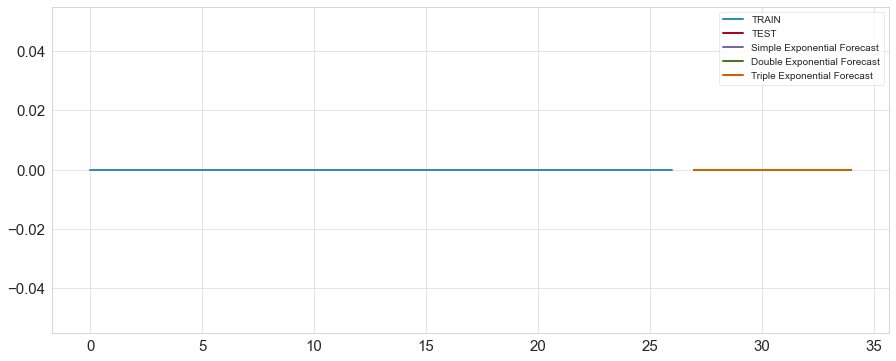

In [52]:
import os
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_cust_RFM/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_cust_prediction/"

for filename in os.listdir(input_folder):
    if filename.endswith(".xlsx"):
        #print(filename)
        file_path = os.path.join(input_folder, filename)

        final_data = future_prediction(file_path)

        
        final_data.to_excel(os.path.join(output_folder, filename))

        #print(file_path)
        #print(final_data)
print("prediction part done")

In [53]:

#creating dashboard back end excel file(adding 2022(rfm,cluster,segmentation) and 2023(rfm,cluster,segmentation) columns)

import pandas as pd
import warnings
warnings.simplefilter("ignore")


# read in the data from an Excel file
df = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/Consolidated_file_sorted.xlsx")

# extract week numbers as integers
df['Week_num'] = df['Week'].str.extract(r'(\d+)').astype(int)

#------------------------------------------------------------------------------------------------------------------------------
# Extract the year from the 'Date' column
df['Year'] = pd.DatetimeIndex(df['Date']).year

# Filter the data frame based on the year
df_2022 = df[df['Year'] == 2022] 
df_2023 = df[df['Year'] == 2023]

# Drop the 'Year' column from both data frames
df_2022.drop('Year', axis=1, inplace=True)
df_2023.drop('Year', axis=1, inplace=True)


# create new columns for 2022 and 2023 weeks
df_2022['2022 Week'] = df_2022['Week']
df_2023['2023 Week'] = df_2023['Week']


# concatenate the two subsets back into the original DataFrame
df = pd.concat([df_2022, df_2023], ignore_index=True)

#------------------------------------------------------------------------------------------------------------------------------

# Create new columns with empty values
df['Monetary_2022'] = ''
df['Total_Receivable_2022'] = ''
df['Date_2022'] = ''



# Create a boolean mask for the rows where "2022 Week" is not null
mask = ~df['2022 Week'].isnull()

# Assign the values to the new columns using the mask
df.loc[mask, 'Monetary_2022'] = df.loc[mask, 'Monetory']
df.loc[mask, 'Total_Receivable_2022'] = df.loc[mask, 'Total Receivable']
df.loc[mask, 'Date_2022'] = df.loc[mask, 'Date']


df['Monetary_2023'] = ''
df['Total_Receivable_2023'] = ''
df['Date_2023'] = ''

# Create a boolean mask for the rows where "2022 Week" is not null
mask = ~df['2023 Week'].isnull()

# Assign the values to the new columns using the mask
df.loc[mask, 'Monetary_2023'] = df.loc[mask, 'Monetory']
df.loc[mask, 'Total_Receivable_2023'] = df.loc[mask, 'Total Receivable']
df.loc[mask, 'Date_2023'] = df.loc[mask, 'Date']

df = df.drop(columns=['Unnamed: 0','Total Receivable', 'RFM_Score', 'Customer_segment','Cluster','Monetory'])#removed monetary column also



print(df.columns)
# save the result to a new Excel file
df.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/Monetory_Actual_values.xlsx", index=False)


Index(['Date', 'Customer', 'Week', 'Week_num', '2022 Week', '2023 Week',
       'Monetary_2022', 'Total_Receivable_2022', 'Date_2022', 'Monetary_2023',
       'Total_Receivable_2023', 'Date_2023'],
      dtype='object')


In [54]:
#split multivalues in cells to columns

import os
import glob
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt


def process_input_file(file_path):
    # read the input file as a DataFrame with temporary header names
    df = pd.read_excel(file_path, header=0)
    df1= df[['Predicted Values','Predicted Weeks', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']]
    df1 = df1.fillna('')
    df_sMAPE =df[['sMAPE Simple ES','sMAPE Double ES','sMAPE Triple ES']]
    # set temporary header names
    temp_header = ["Column" + str(i) for i in range(df1.shape[1])]
    df1.columns = temp_header
    
    new_df = pd.DataFrame()
    
    for col in df1.columns:
        # split the 'Actual Values' column into separate columns
        df_actual = df1[col].str.split('\n', expand=True)
        df_actual = df_actual.transpose()
        df_actual = df_actual.drop(index=(df_actual.shape[0]-1))
        
        new_df = pd.concat([new_df, df_actual], axis=1, ignore_index=False)
    
    # reset header names to None
    #new_df.columns = None
    new_df.columns = ['Predicted Values','Predicted Weeks', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']

    # reset index
    new_df = new_df.reset_index(drop=True)
    #split multi line text in single values to separate columns
    new_df = new_df.apply(lambda x: x.str.split())

    # extract the second value from each cell in all columns(ex- 33 2.321 to 2.321)
    new_df = new_df.apply(lambda x: x.str[1])
    
    #file_name = os.path.basename(file_path)
    file_name, file_extension = os.path.splitext(os.path.basename(file_path))

    #file_name = file_path.split('.')[0]
    # create a new column with the file name
    new_df['customer'] = file_name

    
    
    final_df = pd.concat([new_df, df_sMAPE], axis=1, ignore_index=False)
    final_df = final_df[['customer','Predicted Values','Predicted Weeks', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES','sMAPE Simple ES', 'sMAPE Double ES', 'sMAPE Triple ES']]
    final_df = final_df.fillna(0)
    
    #selecting minimum sMAPE and get best predicted values
    pred_cols  = final_df[['Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']]
    sMAPE_cols = final_df[['sMAPE Simple ES', 'sMAPE Double ES', 'sMAPE Triple ES']]
   
    #sort cloumn names in sMAPEs
    sorted_columns = sMAPE_cols.mean().sort_values().index.tolist()
    
    
    # create an empty list to store the column names
    dup_col = []

    # iterate over the columns
    for col in pred_cols.columns:
        # check if all values in the column are duplicates
        if pred_cols[col].duplicated().all():
            # add the column name to the list
            dup_col.append(col)
    
       
        for i, col in enumerate(sorted_columns):
            
            if col == 'sMAPE Triple ES':
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Triple ES'
            elif col == 'sMAPE Double ES':
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Double ES'
            else:
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Simple ES'

                    
    final_df['best predict'] = final_df[best_col]  
    smape =  sMAPE_cols[sorted_columns[0]]
    final_df['sMAPE'] = smape
    return final_df

In [55]:
#some of monetory predictions are negative here if nessary remove them

#save each dfs in related folderr"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/model_output_data/"
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_cust_prediction/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_cust_prediction_data/"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)

# Loop through each file name and process the corresponding Excel file
for file_name in file_names:
    final_data = process_input_file(file_name)
    #final_data2 = add_week_column(file_name)
   
    #final_data = pd.concat([final_data2,final_data1], axis=1).reset_index(drop=True)
    
    
    output_file_name = os.path.join(output_folder, os.path.basename(file_name))
    output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
    final_data.to_excel(output_file_name, index = False)    
    
    
print("done") #some of monetory predictions are negative here if nessary remove them

done


In [56]:
#duplicate code
#make data frames related to each customer with prediction ,smape,...

import pandas as pd
import numpy as np

input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_cust_prediction_data/"
output_folder= "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_cust_final_df/"

# Set the file pattern want to match

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)

#print(file_names)
for file in file_names:
    df = pd.read_excel(file)

    df_con = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/Monetory_Actual_values.xlsx")


    first_value = df_con['Week_num'].iloc[1]
    last_value = df_con['Week_num'].iloc[-1]

    # calculate the starting week number
    starting_week = last_value -8 + 52
   

    # define the range of values to repeat
    start_val = 1
    end_val = 51
    repeat_val = starting_week

    # calculate the number of times to repeat the range
    num_rows =  len(df.index)
    num_repeats = int(np.ceil(num_rows / (end_val - start_val + 1)))

    # create the array of values to repeat
    vals_to_repeat = np.concatenate((np.arange(start_val, end_val+1),np.arange(repeat_val, end_val+1)))

    # repeat the array the necessary number of times
    repeated_vals = np.tile(vals_to_repeat, num_repeats)[:num_rows]
    # add the repeated values to the new column in the dataframe
    week_vals = [(starting_week + i) % 51 or 51 for i in range(num_rows)]
    df.insert(loc=0, column='Week', value=week_vals)
    last_w = df['Week'].iloc[-1]
    list_week = []
    for i in range (4):
        list_week.append(last_w + i+1)

    df_w = pd.DataFrame({'Week': list_week})
    
    
    # create a new DataFrame with the non-null values of the 'week' column
    df_new = pd.DataFrame(df['Predicted Weeks'].dropna())

    #print(df_new)
    #df = pd.concat([df,df_w], axis =0).reset_index(drop = True)
    df_w['Week'] = 'W' + df_w['Week'].astype(str)
    df_w['Predicted Weeks'] =df_w['Week']
    df_w = df_w.drop('Week', axis=1)
    df_new = pd.concat([df_new,df_w], axis =0).reset_index(drop = True)
    #print(df_new)
    
    df['Week num'] = df_new['Predicted Weeks']
    #print(df_new['Predicted Weeks'])
    
    
    new_cust = pd.DataFrame()
    new_cust['Week num'] = df_new['Predicted Weeks']
    new_cust['Week'] = new_cust['Week num'].str.replace('W', '').astype(int)
    customer_name = df['customer'].iloc[1]

    # Replace the missing values in the "customer" column with the customer name
    new_cust['customer'] = customer_name
    # print(customer_name)
    # print(df)
    new_cust['Predicted Values'] = df['Predicted Values']
    new_cust['Future_prediction'] = ''
    new_cust.loc[8:, 'Future_prediction'] = df.loc[:3, 'best predict'].values
    #df.loc[8:, 'Future_prediction'] = df.loc[:3, 'best predict'].values.tolist() + [""] * (len(df) - 8)
    smape = df['sMAPE'][0]
    new_cust['sMAPE'] =smape #df['sMAPE'].fillna(df['sMAPE'][0], inplace=True)
    
    new_cust = new_cust.fillna(0)
    output_file_name = os.path.join(output_folder, os.path.basename(file))
    output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
    #print(new_cust)
    
    new_cust.to_excel(output_file_name, index = False)   
    
    
print("done")

done


In [57]:
#merge all customer vise prediction files into one file

import pandas as pd

input_folder =  "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_cust_final_df/"
output_file = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_merged_predictions.xlsx"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)


# create empty dataframe to store merged data
merged_df = pd.DataFrame()

# loop through customer files and merge data
for filename in file_names:   # replace file_list with the list of file names in your folder
    df = pd.read_excel(filename)   # read in each file as a data frame
    merged_df = pd.concat([merged_df, df], ignore_index=True)   # append each data frame to the merged data frame

    
    
merged_df['Week'] , merged_df['Week num'] = merged_df['Week num'], merged_df['Week']
# print the merged data frame
print(merged_df.columns)


# drop rows with negative values in "future_prediction" column
merged_df = merged_df.drop(merged_df[merged_df['Future_prediction'] < 0].index)

merged_df.to_excel(output_file)
print("done")

Index(['Week num', 'Week', 'customer', 'Predicted Values', 'Future_prediction',
       'sMAPE'],
      dtype='object')
done


In [58]:
#getting filter values based on weeek number in predictions
import pandas as pd

df = pd.read_excel("C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_merged_predictions.xlsx")
#df.head()

df_con = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/Monetory_Actual_values.xlsx")


first_value = df_con['Week_num'].iloc[1]
last_value = df_con['Week_num'].iloc[-1]

# calculate the starting week number
starting_week = last_value -6 + 52


start_val = 1
end_val = 51
repeat_val = starting_week

# calculate the number of times to repeat the range
num_rows =  len(df.index)
num_repeats = int(np.ceil(num_rows / (end_val - start_val + 1)))

# create the array of values to repeat
vals_to_repeat = np.concatenate((np.arange(start_val, end_val+1),np.arange(repeat_val, end_val+1)))

# repeat the array the necessary number of times
repeated_vals = np.tile(vals_to_repeat, num_repeats)[:num_rows]
# add the repeated values to the new column in the dataframe
week_vals = [(starting_week + i) % 51 or 51 for i in range(num_rows)]

pred_starting_week = (starting_week+6) % 51

print(pred_starting_week)
week_filter = [0]*4
for i in range(4):
    week_filter[i]= pred_starting_week +i

    
#print(week_filter)

# create an empty list to store the filtered DataFrames
df_list = []

# loop over each value in week_list and filter the DataFrame
for week in week_filter:
    df_filtered = df[df['Week num'] == week]
    df_list.append(df_filtered)

# concatenate all the DataFrames in df_list into one DataFrame
df_combined = pd.concat(df_list)


# convert Future_prediction column to float
df_combined['Future_prediction'] = df_combined['Future_prediction'].astype(float)
    

# # apply the function to create a new column
# df_combined['Predicted_Customer_Segmentation'] = df_combined['Future_prediction'].apply(map_to_segment)
# df_combined['Predicted_Customer_Cluster'] = df_combined['Future_prediction'].apply(map_to_cluster)

df_to_actual = df_combined[['Week', 'customer','Week num', 'Future_prediction','sMAPE']]


print(df_to_actual)

df_to_actual.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_prediction_values_merge.xlsx", index=False)


22
    Week                          customer  Week num  Future_prediction  \
8    W22   Abercrombie & Fitch Trading Co.        22       3.111987e+05   
20   W22                             Aerie        22       2.692807e+06   
32   W22  AMAZON ESSENTIAL - SPOTTED ZEBRA        22       2.042116e+04   
44   W22                         Amazon UK        22       7.327682e+04   
56   W22    AMERICAN DESIGNER FASHION, S.A        22       6.644386e+03   
..   ...                               ...       ...                ...   
289  W25                 Puritas (Pvt) Ltd        25       5.022088e+04   
301  W25                  PVH ASIA LIMITED        25       4.816657e+04   
321  W25                  Summersalt, Inc.        25       1.574864e+06   
333  W25   The Colombo Fashion WSwim Pvt L        25       1.997185e+03   
345  W25             Urban Island and FMLK        25       0.000000e+00   

          sMAPE  
8     47.207901  
20   106.592320  
32     0.660268  
44    23.133443  
56    

In [59]:
#concat Actual and prediction data frames in to one df
import pandas as pd 
import numpy as np

df_actual = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/data_files/Monetory_Actual_values.xlsx")
df_predict = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_prediction_values_merge.xlsx")
#df_reference =  pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Nature.xlsx")


df_actual['Future_prediction'] = ''
df_actual['sMAPE'] = ''

# df_actual['Predicted_Customer_Segmentation'] = ''
# df_actual['Predicted_Customer_Cluster'] = ''

# #chechk always if Unnamed: 0 column exists if its availble drop it(if it availble its harder to concat dfs)
# if 'Unnamed: 0' in df.columns:
#     df_actual.drop(columns=['Unnamed: 0'], inplace=True)

df_predict.rename(columns={'customer': 'Customer'}, inplace=True)
df_predict.rename(columns={'Week num': 'Week_num'}, inplace=True)


# ['Customer', 'Week', 'Monetory', 'Week_num', '2022 Week', '2023 Week','Monetary_2022', 'Monetary_2023'],

# Index(['Week', 'customer', 'Week num', 'Future_prediction', 'sMAPE'], dtype='object')



# creating null column because of concat
df_predict[['Monetory', '2022 Week', '2023 Week', 'Monetary_2022', 'Monetary_2023','Total_Receivable_2022','Total_Receivable_2023']] = None

print(df_actual.columns)
print(df_predict.columns)


#common_cols = list(set(df_actual.columns) & set(df_predict.columns))
df_actual = pd.concat([df_actual, df_predict], axis=0).reset_index()


#df_merged = pd.merge(df_actual, df_reference, on='Customer', how='left')

df_actual.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_pbi_file_1.xlsx")

Index(['Date', 'Customer', 'Week', 'Week_num', '2022 Week', '2023 Week',
       'Monetary_2022', 'Total_Receivable_2022', 'Date_2022', 'Monetary_2023',
       'Total_Receivable_2023', 'Date_2023', 'Future_prediction', 'sMAPE'],
      dtype='object')
Index(['Week', 'Customer', 'Week_num', 'Future_prediction', 'sMAPE',
       'Monetory', '2022 Week', '2023 Week', 'Monetary_2022', 'Monetary_2023',
       'Total_Receivable_2022', 'Total_Receivable_2023'],
      dtype='object')


In [4]:
#filter each cusromer and get all data in single data frame 

#consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\data_files\Consolidated_file_sorted.xlsx')
import pandas as pd
import os

consolidate_df = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_pbi_file_1.xlsx")

# Get unique customer names
customer_names = consolidate_df["Customer"].unique()
#print(customer_names)

dfs = []
# Iterate over each customer and create a separate Excel file
for customer in customer_names:
    # Filter the dataframe for the current customer
    #customer_df = consolidate_df[consolidate_df["Customer"] == customer][["RFM_Score", "Customer_segment", "Week", "Cluster","Monetory"]]
    customer_df1 = consolidate_df[consolidate_df["Customer"] == customer][["Date","Customer", "Week","Monetory","Week_num","2022 Week","2023 Week","Monetary_2022","Monetary_2023","Total_Receivable_2022","Total_Receivable_2023","Future_prediction","sMAPE"]]
    
    
    #add Week column which include W1 to W51 
    weeks = ['W'+str(i) for i in range(1,52)]
    oder =  [i for i in range(1,52)]
    customer = customer_df1["Customer"].iloc[1]
    # create a dictionary with the column names and values
    data = {'Customer': [str(customer)]*51, 'Week': weeks,'Oder':oder}

    # create a dataframe from the dictionary
    customer_df2 = pd.DataFrame(data)
    # print(customer_df2.tail())
    # print(customer_df1.tail())

    full_join_df = pd.merge(customer_df2,customer_df1, on ="Week", how ="outer")
    
    #print(full_join_df.head())
    
    
    
    # Create output file name
    output_file_name = f"{customer}.xlsx"
    #output_folder = r"C:/Users/GCV/Documents/MAS/Project AR/con_output/"
    output_folder1 = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/test/"
   
    #output_file_path = os.path.join(output_folder, output_file_name)
    output_file_path1 = os.path.join(output_folder1, output_file_name)
    full_join_df = full_join_df.drop('Customer_y', axis = 1)
    dfs.append(full_join_df)
    
    
    
#     #Assuming your DataFrame is named 'df' and the column is named 'b'
#     index_last_non_null = full_join_df['Monetary_2023'].last_valid_index()
#     #print(index_last_non_null)

#     column_name_1 = 'Monetary_2023'
#     column_name_2 = 'Future_prediction'


#     value = full_join_df.loc[index_last_non_null, column_name_1]
#     full_join_df.loc[index_last_non_null, column_name_2] = value


    

    full_join_df.to_excel(output_file_path1, index=False)



In [ ]:
import pandas as pd
import os
import glob

input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/test/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/test2/"

# Set the file pattern you want to match, for example, all files with ".xlsx" extension
file_pattern = input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)

for filename in file_names:
    try:
        df = pd.read_excel(filename)  # Read in each file as a DataFrame

        index_last_non_null = df['Monetary_2023'].last_valid_index()
        #print(filename, index_last_non_null)

        if index_last_non_null is None:
            print(f"Ignoring {filename} due to None values in the index.")
            continue  # Skip the current file and move to the next iteration

        column_name_1 = 'Monetary_2023'
        column_name_2 = 'Future_prediction'

        value = df.loc[index_last_non_null, column_name_1]
        df.loc[index_last_non_null, column_name_2] = value
        value2 = df.loc[index_last_non_null, column_name_2]

        # # Get the base name of the input file
        base_name = os.path.basename(filename)
        # Remove the ampersand character from the base name
        #base_name = base_name.replace("&", "")
        # Create the output file path by joining the output folder and the modified base name
        output_file_path = os.path.join(output_folder, base_name)
        #print(output_file_path)
        # Save the modified DataFrame to the output file
        df.to_excel(output_file_path, index=False)

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue  # Skip the current file and move to the next iteration


In [6]:
#getting final output excel file

import pandas as pd
import os
import glob

input_folder =  "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/test2/"
output_file = "C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_merged_predictions.xlsx"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)


# create empty dataframe to store merged data
merged_df = pd.DataFrame()

# loop through customer files and merge data
for filename in file_names:   # replace file_list with the list of file names in your folder
    df = pd.read_excel(filename)   # read in each file as a data frame

    merged_df = pd.concat([merged_df, df], ignore_index=True)   # append each data frame to the merged data frame
    

merged_df = merged_df.drop('Monetory',axis =1)

#merged_df = merged_df.fillna(0) #'Unnamed: 0.1','Unnamed: 0',
#merged_df = merged_df.drop(['index','Customer'], axis=1)
merged_df = merged_df.rename(columns={'Customer_x': 'Customer'})



#make oder for each week to sort power bi dashboard
week_order = {'W1': 1, 'W2': 2, 'W3': 3, 'W4': 4, 'W5': 5, 'W6': 6, 'W7': 7, 'W8': 8, 'W9': 9, 'W10': 10, 'W11': 11, 'W12': 12, 'W13': 13, 'W14': 14, 'W15': 15, 'W16': 16, 'W17': 17, 'W18': 18, 'W19': 19, 'W20': 20, 'W21': 21, 'W22': 22, 'W23': 23, 'W24': 24, 'W25': 25, 'W26': 26, 'W27': 27, 'W28': 28, 'W29': 29, 'W30': 30, 'W31': 31, 'W32': 32, 'W33': 33, 'W34': 34, 'W35': 35, 'W36': 36, 'W37': 37, 'W38': 38, 'W39': 39, 'W40': 40, 'W41': 41, 'W42': 42, 'W43': 43, 'W44': 44, 'W45': 45, 'W46': 46, 'W47': 47, 'W48': 48, 'W49': 49, 'W50': 50, 'W51': 51, 'W52': 52}

merged_df['week_order'] = merged_df['Week'].map(week_order)
#merged_df = merged_df.sort_values('week_order')

#remove time part
merged_df['Date'] = merged_df['Date'].dt.date
# merged_df['Date_2022'] = merged_df['Date_2022'].dt.date
# merged_df['Date_2023'] = merged_df['Date_2023'].dt.date




#merged_df.to_excel(output_file)
merged_df.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_pbi_file_final_1.xlsx")
print("done")
print(merged_df.head())

done
                          Customer Week  Oder        Date  Week_num 2022 Week  \
0  Abercrombie & Fitch Trading Co.   W1     1  2023-01-02       1.0       NaN   
1  Abercrombie & Fitch Trading Co.   W2     2  2023-01-09       2.0       NaN   
2  Abercrombie & Fitch Trading Co.   W3     3  2023-01-16       3.0       NaN   
3  Abercrombie & Fitch Trading Co.   W4     4  2023-01-23       4.0       NaN   
4  Abercrombie & Fitch Trading Co.   W5     5  2023-01-30       5.0       NaN   

  2023 Week  Monetary_2022  Monetary_2023  Total_Receivable_2022  \
0        W1            NaN      349922.29                    NaN   
1        W2            NaN      145975.80                    NaN   
2        W3            NaN      147520.38                    NaN   
3        W4            NaN      257317.71                    NaN   
4        W5            NaN      268928.06                    NaN   

   Total_Receivable_2023  Future_prediction  sMAPE  week_order  
0              845774.58          

In [7]:
#adding validation line
import pandas as pd
import numpy as np

df1 = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_pbi_file_final_1.xlsx")
df2 = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_merged_predictions.xlsx")

df2 = df2[['Week', 'customer', 'Predicted Values']]
df2 = df2.rename(columns={'customer': 'Customer'})
df2 = df2.replace(0, np.nan)

print(df2.columns)

# merge df1 and df2 on 'Week' and 'Customer' columns
result_df = pd.merge(df1, df2, on=['Week', 'Customer'], how='outer')

#result_df['Date'] = result_df['Date'].dt.date
#result_df = result_df.drop('Date', axis=1)
if 'Unnamed: 0'in result_df.columns:
    result_df = result_df.drop('Unnamed: 0', axis=1)

result_df.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Demo/monetory_pbi_file_final.xlsx")


Index(['Week', 'Customer', 'Predicted Values'], dtype='object')
